# Predicting Controversy in Reddit Posts: A Supervised Learning Approach

## Introduction
Online platforms are always making constant decisions about what to show, suppress, or highlight to users. Every recommendation made to a user reflects some inherent underlying model of what people likely care about. Most of the time, these models focus on the notion of popularity by attempting to bring posts that will be heavily interacted with to the surface. However, not all engagement is the same. Some content consistently gains upvotes because everyone comes to a consensus that it is harmless or funny, while other content sparks divides in the audience and creates long chains of back and forth replies between users. From a modeling perspective, these posts that generate polarized reactions not only present a unique challenge, but also provide a more meaningful indication about user preferences than simple popularity metrics can really capture. 

In this project, we explicitly focus on that second category and treat controversy as the target we are trying to predict. As opposed to simply questioning "which posts will be most popular?", we frame our primary research question to identify "which posts are likely to generate a lot of activity because people disagree about them?" This distinction is important to highlight for multiple reasons. For instance, different platforms might value different approaches to controversial content. While some platforms might want to suppress highly controversial content if they are trying to reduce conflict between users, others may want to deliberately highlight it if they value the boosted engagement derived from it. 

Reddit is a natural setting for this question due to its unique interaction mechanics. Unlike platforms designed primarily for media viewing, such as TikTok, Reddit's appeal and value lies in its comment sections, where users interact with the original poster or with one another. The site contains engagement metrics like upvotes, downvotes, and comment counts, which all provide signal about the popularity of a post and how divided the audience is in response to it. In this project, we use the Reddit Resubmissions dataset, which aggregates thousands of posts featuring images that have appeared multiple times on the site, along with their titles, timestamps, vote statistics, comment counts, and which subreddit it comes from. Using these signals, we frame controversy prediction as a supervised learning problem: given what is known at the moment of submitting a new reddit post, can we predict which posts are likely to spark widespread disagreement across users? 

## 1. Predictive Task: Identifying Controversial Reddit Posts

Predicting controversy requires us to be precise about what kind of behavior we want the model to capture. As previously mentioned, many supervised learning projects based on social media data will mainly focus on popularity by attempting to forecast which posts will receive the most attention or who will engage with them. Controversy is more subtle. It reflects not just how many people interact with a post, but how divided and potentially problematic that interaction is. A post that is mostly agreed upon will naturally behave very differently from one that receives a lot of upvotes/downvotes and long chains of arguments in the comments. Our goal is to distinguish between these two categories solely based on information available at submission time. 

#### 1.1. Task definition:

We frame the task as a **binary classification** problem. Given a newly submitted Reddit post, which includes its title, subreddit, timestamp, and other metadata provided in the dataset, the goal is to predict whether the post will ultimately become controversial or not.

#### 1.2. Why focus on controversy:

Focusing on controversy instead of popularity lets us look at a different dimension of platform dynamics. While popular posts tell us what the majority of people agree on, controversial posts tell us where public opinion diverges. This difference does have important practical implications for platforms trying to improve their recommendation algorithms, whether they might want to capitalize on controversy by promoting it or suppress it entirely to limit debate between users.

To make this more concrete, we center the project around the following question:

> **Main research question**: Given a new Reddit post (its title, subreddit, timestamp, and other metadata available at submission time), can we predict whether it will eventually become controversial, meaning that it receives a high volume of votes and comments with a roughly balanced mix of upvotes and downvotes?

#### 1.3. Conceptual definition of controversy:

Since the dataset does not contain a "controversy" label, we must operationalize the definition of controversy ourselves. From a conceptual perspective, we say a post is controversial if it receives a high level of overall engagement combined with a roughly balanced mix of positive and negative feedback. Practically, this means two things. First, a post must surpass a certain threshold on the total number of interactions (upvotes, downvotes, and comments) to even be a candidate. Second, among these posts with high levels of engagement, we can gauge how balanced the user reaction is by creating a ratio of upvotes and downvotes, namely by calculating the smaller number of the upvotes and downvotes divided by the larger one. Posts with both high engagement and a high enough balance ratio can be labeled as "controversial", while all others are labeled "not controversial." This effectively gives us labels for our downstream binary classification task. In the exploratory data analysis section, we will expand upon these definitions and choose concrete thresholds based on the actual distributions present in the data. 


#### 1.4. Evaluation Strategy:

To answer this question, we need to focus on evaluation metrics that reflect how rare controversial posts can be. Using accuracy as the only evaluation metric would be misleading, because a model could achieve high accuracy by predicting the majority class of "not controversial" every single time. Instead, we should use metrics that accurately evaluate the performance on the controversial class itself. Precision tells us how often posts predicted to be controversial actually are, while recall tells us how many actually controversial posts we are able to correctly identify out of all the controversial posts in the dataset. Using their harmonic mean, which is expressed in the F1 score, gives us a balanced summary of performance especially when looking at the minority class. We will also report Area Under the Receiver Operating Characteristic Curve (AUC), which expresses how well the model separates controversial from non-controversial posts.

In terms of evaluation procedures, we will split the data into training, validation, and test portions. The training set will be used to fit the model, while the validation set is used for hyperparameter tuning and potentially choosing between different models, and the test set will be used exclusively to report model performance. 

#### 1.5 Relevant baseline models

We will select three main models relevant to the course content in CSE 158: Web Mining and Recommender Systems to use as our baselines:
- **Majority-class predictor**  
    This model always predicts that a post is not controversial, which reflects the class distribution of our dataset and also sets the minimal level of performance that any reasonable model should  surpass.
- **Logistic regression with metadata**  
    Here, we use a simple linear classifier with features like subreddit (one-hot encoded), hour of day, day of week, and title length. This baseline looks at if temporal and patterns within subreddits are sufficient for identifying posts that are likely to become controversial, without even looking at the language of the title itself.
- **Jaccard similarity baseline (similar posts)**  
    The third baseline is a similarity based approach by representing each post title as a set of tokens and measuring the Jaccard Similarity between titles:
      $$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
    For a new post, we find the most similar past posts using Jaccard similarity and look at how many were labeled as controversial. If enough of its nearest neighbors are controversial, we predict that the post will also be controversial, and the converse also applies. This baseline lets us explore a simple question: "Do posts that have similar titles to previously controversial posts tend to become controversial as well?"

#### 1.6 Assessing the validity of model predictions

Besides reporting performance metrics, we also want to make sure that the model is able to generalize well to unseen data as opposed to overfitting to the dataset itself. To do this, we will evaluate all models on a test set that was not used during model training or hyperparameter tuning. We will compare our main model against multiple baselines to make sure that the improvement is not attributed to random chance or due to the majority of posts being non-controversial.  Because controversial posts are generally rare, we also need to make sure to select suitable metrics for this task such that the models are identifying controversial posts in a meaningfu, which will be elaborated upon in a later section.

## 2. Exploratory analysis, data collection, pre-processing, and discussion

#### 2.1 Context

The dataset used in this project is the *Reddit Resubmissions* dataset from the Stanford Network Analysis Project (SNAP). It contains over one hundred thousand Reddit posts that have appeared multiple times on the platform. Each entry in the dataset represents a reddit post and it's image, title, user, subreddit, timestamp, and several other engagement metrics such as the number of upvotes. 


> Understanding the interplay between titles, content, and communities in social media
Himabindu Lakkaraju, Julian McAuley, Jure Leskovec
ICWSM, 2013


#### 2.2 Analysis

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/redditSubmissions.csv.gz', on_bad_lines="skip")
df.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,1844.0,622.0,Animates_Everything
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,Gangsta_Raper
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,Gangsta_Raper
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,Every time I downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,Gangsta_Raper
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,Gangsta_Raper


#### 2.2.1 Feature Overview

The dataset provides several engagement related attributes:
- `number_of_upvotes`
- `number_of_downvotes`
- `score` (difference between upvotes and downvotes)
- `number_of_comments`
- `total_votes`

Before we build a controversy label, we should examine through descriptive statistics:
1. How often do posts receive large amounts of engagement?
2. How balanced are upvotes vs. downvotes?
3. What is the distribution of high engagement across subreddits?

In [4]:
df[['total_votes', 'number_of_upvotes', 'number_of_downvotes', 'number_of_comments', 'score']].describe()

,total_votes,number_of_upvotes,number_of_downvotes,number_of_comments,score
count,132302.000000,132302.000000,132302.000000,132302.000000,132302.000000
mean,1883.245748,1058.182900,825.062849,39.063400,233.120051
std,5970.693071,3181.146483,2796.540029,142.742878,481.126196
min,0.000000,0.000000,0.000000,-1.000000,-264.000000
25%,15.000000,8.000000,6.000000,0.000000,2.000000
50%,45.000000,30.000000,14.000000,3.000000,16.000000
75%,376.000000,276.000000,96.000000,15.000000,169.000000
max,177103.000000,90396.000000,86707.000000,8357.000000,20570.000000


From these statistics, we can see that every feature related to votes heavily differ between the median and the maximum, indicating an extremely skewed distribution. This suggests that only a very small fraction of posts actually receive high levels of engagement, while the majority of posts are barely interacted with.
- Median total votes = **45**
- Maximum total votes = **177,103**

We can also observe that upvotes are heavily favored over downvotes for most posts. Combined with very high standard deviations, this confirms that most posts are not balanced in terms of upvotes and downvotes (which is needed for controversy).
- Median upvotes = **30**
- Median downvotes = **14**

Comments also seem to be even more skewed than votes, with the majority of posts getting almost none. The majority of posts seem to not create extended back and forth discussions per users. Additionally, comment count is an important signal that we can use for identifying posts that spark debate.
- Median comments = **3**
- 75th percentile = **15**
- Maximum = **8,357**

Overall, these descriptives help frame our labeling strategy. They demonstrate how controversial posts will be rare but stand out distinctively. Our high engagement threshold must be based on quantiles (ex: top 10%) since absolute numbers can be misleading. Using a balance ratio for upvotes and downvotes is important because the average post is not balanced. 

#### 2.2.2 Visualizing distributions

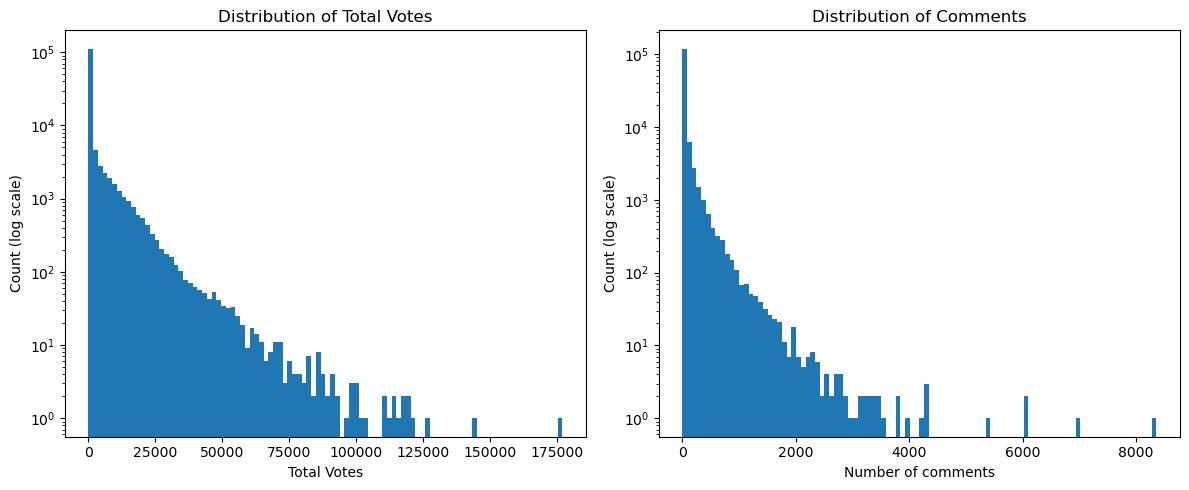

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(df['total_votes'], bins=100, log=True)
axes[0].set_xlabel("Total Votes")
axes[0].set_ylabel("Count (log scale)")
axes[0].set_title("Distribution of Total Votes")

axes[1].hist(df['number_of_comments'], bins=100, log=True)
axes[1].set_xlabel("Number of comments")
axes[1].set_ylabel("Count (log scale)")
axes[1].set_title("Distribution of Comments")

plt.tight_layout()
plt.show()


The histograms above show the distribution of `total_votes` and `number_of_comments` on a logarithmic scale. Using a log scale allows us to visualize the high volume of low engagement posts and the very sparse high engagement posts simultaneously. From this, we can tell that the distribution is extremely right skewed, where the majority of posts receive low levels of engagement, while a small fraction of posts receive extremely high levels of engagement. The tail extends all the ways into hundreds of thousands of total votes, showcasing that a small subset of posts dominate the activity on the platform. Comments seem to exhibit a similar trend.

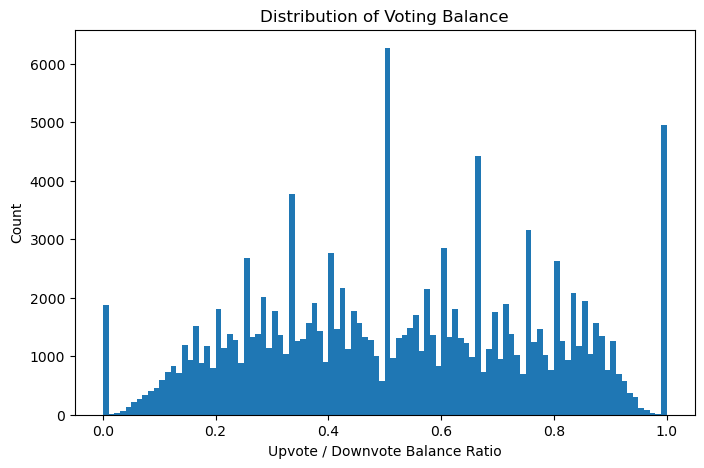

In [6]:
df['balance_ratio'] = (df[['number_of_upvotes','number_of_downvotes']].min(axis=1) /df[['number_of_upvotes','number_of_downvotes']].max(axis=1))

plt.figure(figsize=(8,5))
plt.hist(df['balance_ratio'], bins=100)
plt.xlabel("Upvote / Downvote Balance Ratio")
plt.ylabel("Count")
plt.title("Distribution of Voting Balance")
plt.show()

As previously mentioned, to quantify how balanced the feedback a post receives is, we operationalize a voting balance ratio, defined as:
$$ \text{balance-ratio} = \frac{\min(\text{upvotes}, \text{downvotes})}{\max(\text{upvotes}, \text{downvotes})} $$

A value near 0 means the post is extremely one sided (mostly upvotes or downvotes). On the other hand, a value near 1 means the post received a nearly equal number of upvotes and downvotes, which indicates mixed reactions.

The histogram above shows the distribution of this balance ratio across all the posts in the dataset. Surprisingly, the dataset showcases a wide spread of balance ratios in a somewhat uniform distribution. We observe a large spike at 1.0, which belongs to posts where the number of upvotes and downvotes is exactly equal. Conversely, we also see a handful of posts at 0.0, indicating posts that are either entirely upvotes or downvotes.


#### 2.3 Choosing controversy thresholds

In [7]:
vote_thresh = df['total_votes'].quantile(0.90)

df['is_controversial'] = (
    (df['total_votes'] >= vote_thresh) &
    (df['balance_ratio'] >= 0.3)
).astype(int)

counts = df['is_controversial'].value_counts().sort_index()
summary = pd.DataFrame({
    "label": ["non-controversial", "controversial"],
    "count": counts.values,
    "fraction": (counts / counts.sum()).values
})

summary

,label,count,fraction
0,non-controversial,119078,0.90004
1,controversial,13225,0.09996


To transform our definition of controversy into an actual label, we first set a high engagement threshold at the 90th percentile of `total_votes`. Then, we mark a post as controversial if it exceeds this threshold and also has a voting balance ratio of at least 0.3.

The summary table above shows that using this set of thresholds, about 10% of posts are labeled as controversial and 90% are non-controversial. This reaffirms our assumption that controversy is the minority class.

#### 2.4 Pre-processing and Feature Engineering

Before we proceed to building our models, we take preprocessing steps to ensure that the data is clean and that excessive noise is filtered out.

##### Handling missing values

In the descriptive statistics, we saw that some posts contain a value of -1 for `number_of_comments`, which can be assumed to indicate missing values in the SNAP dataset. We convert these entries to 0.

In [8]:
df['number_of_comments'] = df['number_of_comments'].clip(lower=0)

##### Creating the balance ratio

In [9]:
df['balance_ratio'] = (
    df[['number_of_upvotes','number_of_downvotes']].min(axis=1) /
    df[['number_of_upvotes','number_of_downvotes']].max(axis=1)
)

df['balance_ratio'] = df['balance_ratio'].fillna(0) # fill missing values with 0

##### Extracting time features

We impute missing `hour` and `dayofweek` values with the most common value as well as any missing `title_length` with the median length to handle missingness in the dataset.

In [10]:
parsed_time = pd.to_datetime(df['rawtime'], errors='coerce', utc=True)

df['hour'] = parsed_time.dt.hour
df['dayofweek'] = parsed_time.dt.dayofweek
df['title_length'] = df['title'].astype(str).str.len()

df['hour'] = df['hour'].fillna(df['hour'].mode()[0])
df['dayofweek'] = df['dayofweek'].fillna(df['dayofweek'].mode()[0])
df['title_length'] = df['title_length'].fillna(df['title_length'].median())

##### One-hot encoding subreddit

In [11]:
subreddit_dummies = pd.get_dummies(df['subreddit'], prefix='sub')

##### Converting titles into text based-features

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
title_tfidf = tfidf.fit_transform(df['title'].astype(str))

## 3. Modeling


#### 3.1 Problem Formulation

Our task is a **binary classification** problem. It is important to note that we will not be using `total_votes`, `number_of_upvotes`, `number_of_downvotes`, `number_of_comments`, or `balance_ratio` as input features due to the way we framed our task. We are specifically predicting if a post will become controversial based on what is known at the exact moment of submitting a new Reddit post.

For each reddit post, the inputs are:
- Title text (TF-IDF vector)
- Subreddit (one-hot encoding)
- Time features: `hour`, `dayofweek`
- `title_length`

The outputs are:
- `1` if the post is labeled **controversial**
- `0` otherwise

We build a feature matrix that combines `hour` and `dayofweek`, `title_length`, and the `subreddit` one-hot encodings. We partition the full dataset into a 70/15/15 train/validation/test split using stratified sampling for training our model, model selection, and final evaluation. Stratification helps ensure that all three splits reflect the percentage of controversial posts in distribution of the full dataset.

During training, our models will optimize binary cross entropy loss (logistic loss) between the predicted probability of a post being controversial and the true label. 

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

y = df['is_controversial'].values
titles = df['title'].astype(str).values

meta_cols = ['hour', 'dayofweek', 'title_length']
X_meta = df[meta_cols].values
X_sub = subreddit_dummies.values
X_meta_sub = np.hstack([X_meta, X_sub])

N = len(df)
all_idx = np.arange(N)

train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_idx, y, test_size=0.3, random_state=42, stratify=y
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_meta_sub_train = X_meta_sub[train_idx]
X_meta_sub_val   = X_meta_sub[val_idx]
X_meta_sub_test  = X_meta_sub[test_idx]

train_titles = titles[train_idx]
val_titles   = titles[val_idx]
test_titles  = titles[test_idx]

train_labels = y_train


#### 3.2 Model choices

In this section, we implement the baseline models and compare their performance to a more expressive main model. We discuss each models' advantages, tradeoffs, and limitations in detail.

#### 3.2.1 Majority class baseline

This model always predicts a new post as "not controversial." It ignores any features in the dataset and only reflects the class distribution in the dataset. 

**Advantages**:
- Extremely simple to implement, no training required
- Offers a clear lower bound on model performance

**Disadvantages**:
- F1 and recall for controversial posts will be 0
- Unable to learn any meaningful representations from the data


In [14]:
from sklearn.dummy import DummyClassifier

majority_clf = DummyClassifier(strategy="most_frequent")
majority_clf.fit(X_meta_sub_train, y_train)

DummyClassifier(strategy='most_frequent')

#### 3.2.2 Logistic regression with metadata baseline

We train a logistic regression model and optimize it via logistic loss using only the metadata features: `subreddit` one-hot encodings, `hour`, `dayofweek`, and `title_length`. This allows us to understand how accurately we can predict controversy using only where and when something is posted, as well as how long the title is.

**Advantages**:
- Fast and scales well on high dimensional sparse features
- Coefficients are intereptable (e.g. which subreddits or times are associated with controversy)
- Has a convex objective function, so training will converge to a global optimum instead of getting stuck in a local minima

**Disadvantages**:
- The decision boundary is linear, making it unable to capture more complex interactions
- Ignores the meaning of the title, which contains important signals for prediction


In [15]:
from sklearn.linear_model import LogisticRegression

logreg_meta = LogisticRegression(max_iter=1000)
logreg_meta.fit(X_meta_sub_train, y_train)

LogisticRegression(max_iter=1000)

#### 3.2.3 Jaccard similarity baseline

This is a similarity based baseline that only uses the title text. We evaluate the Jaccard baseline separately by splitting the list of titles into train/validation test partitions, computing token sets for the titles in the training set, and then finally predicting the label for each title in the test set based on its nearest neighbors based on Jaccard similarity:
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$  

For this baseline, exact nearest neighbor search over the entire training set is very computationally expensive due to its quadratic time complexity. Instead, we will evaluate the baseline on a random subset of 10k training titles and 3k test titles. This still provides a reasonable comparison but also underestimates the performance of using the entire training set.

When looking at a new post, we find the most similar titles in the training set and see how many of those neighbors are labeled as controversial. If a large enough fraction are controversial, we predict the new post will be controversial as well. 

**Advantages**:
- Easy to interpret, predictions are based on similar past posts
- Non-parametric, also does not require gradient-based training

**Disadvantages**:
- Computationally expensive when predicting new posts (needs to compare a lot of titles in training)
- Sensitive to variations in vocabulary and tokens
- Uses only title text and ignores subreddit and time

In [16]:
import numpy as np

def tokenize(s):
    return set(s.lower().split())

max_train_j = 10_000
n_train = len(train_titles)

if n_train > max_train_j:
    rng = np.random.default_rng(42)                
    subset_idx = rng.choice(n_train, size=max_train_j, replace=False)
    j_train_titles = train_titles[subset_idx]
    j_train_labels = train_labels[subset_idx]
else:
    j_train_titles = train_titles
    j_train_labels = train_labels

train_token_sets = [tokenize(t) for t in j_train_titles]

def jaccard(a, b):
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union > 0 else 0.0

def predict_jaccard(title, k=5, thresh=0.5):
    tokens = tokenize(title)
    sims = np.array([jaccard(tokens, ts) for ts in train_token_sets])
    nn_idx = sims.argsort()[-k:]           
    nn_labels = j_train_labels[nn_idx]     

    frac_controversial = nn_labels.mean()
    return 1 if frac_controversial >= thresh else 0

y_pred_j = np.array([predict_jaccard(t) for t in test_titles])

#### 3.2.4 Main model: XGBoost with TF-IDF + metadata

Our main model is a gradient boosted deicsion tree classifier (XGBoost) that relies on the following features:
- TF-IDF features from the title of the post
- Metadata features: `hour`, `dayofweek`, `title_length`
- `subreddit` one-hot encodings

XGBoost is suited for this task because of its proficiency at modeling non-linear interactions as well as handling class imbalance. We optimize logistic loss to learn a probabilistic classifier.

**Advantages**:
- Able to capture complex relationships between text features and metadata
- Handles sparse and dense inputs well
- Typically achieves strong performance on tabular and text-based tasks

**Disadvantages**:
- More computationally expensive than the baselines, specifically logistic regression
- Less intereptable compared to a linear model (where we can interpret coefficients)
- Dependent on hyperparameter tuning

In [17]:
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

# combine metadata + subreddit with TF-IDF title features
X_meta_sub_sparse = csr_matrix(X_meta_sub)
X_full = hstack([X_meta_sub_sparse, title_tfidf])

# base XGBoost model
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
)

## 4. Evaluation

#### 4.1 Context

As previously mentioned, relying on only raw accuracy as the main metric would be misleading. A classifier that always predicts the majority class, in this case "not controversial", would achieve ~90% accuracy while never predicting a single controversial post. Instead, we focus on metrics that measure performance on the controversial class:
- **Precision**: for posts predicted to be controversial, how many actually are?
- **Recall**: for all truly controversial posts, how many do we correctly identify?
- **F1 score:** harmonic mean of precision and recall, provides us with a single summary that balances the two metrics
- **AUC (ROC)**: how well the model separates controversial from non-controversial posts. AUC = 1.0 implies perfect separation.

$$\text{Precision} = \frac{TP}{TP + FP} \quad\quad \text{Recall} = \frac{TP}{TP + FN}$$

$$\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

#### 4.2 Hyperparameter tuning for XGBoost
For our XGBoost model, we will perform a grid search over `depth`, `learning_rate`, and number of trees (`n_estimators`) using 5-fold cross validation on the training data to optimize F1 score while accounting for class imbalance. Afterwards, we keep the best model (`best_xgb`) and evaluate it later on the test set alongside the baseline models.

In [18]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# use only the training portion for hyperparameter tuning
X_train_full = X_full[train_idx]
y_train_full = y_train

# hyperparameter grid
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="f1",   
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_full, y_train_full)

best_xgb = grid.best_estimator_
print("Best params:", grid.best_params_)

X_test_full_unified = X_full[test_idx]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}


From the grid search, we observe that the best combination of hyperparameters for our XGboost model is `learning_rate` = 0.1, `max_depth` = 6, and `n_estimators` = 300. Having a tree depth of 6 allows the model to capture more complex interactions, while having a high number of trees at 300 combined with a lower learning rate allows the model to gradually correct errors without overfitting.

#### 4.3 Choosing a decision threshold

As mentioned previously, the amount of posts that are labeled as controversial is extremely imbalanced, with only roughly 10% of posts being marked as such. If we default to using the 0.5 decision threshold, the model will predict a new post to be controversial if it outputs a score greater than 0.5. Otherwise, it will labeled as non-controversial. As a result, our models will tend to predict every single post as non-controversial. The tradeoff here is that accuracy is maximized but precision, recall, and F1 would all be near zero for the controversial class. 

To make the models actually useful for detecting controversial posts, we instead tune the decision threshold on the validation set. For logistic regression and XGboost, we search through several different candidate thresholds and pick the one that maximizes F1 score for the controversial class while keeping validation accuracy above 85%.

In [29]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import numpy as np

def find_best_threshold(model, X_val, y_val, min_acc=0.85):
    if not hasattr(model, "predict_proba"):
        return 0.5, None

    scores = model.predict_proba(X_val)[:, 1]

    best_t = 0.5
    best_f1 = -1.0  # so any valid F1 beats it
    best_acc = None

    for t in np.linspace(0.05, 0.5, 20):
        y_hat = (scores >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val, y_hat, average="binary", pos_label=1, zero_division=0
        )
        acc = accuracy_score(y_val, y_hat)

        if acc < min_acc:
            continue

        if f1 > best_f1:
            best_f1 = f1
            best_t = t
            best_acc = acc

    # if nothing met the accuracy floor, just fall back to 0.5
    if best_f1 < 0:
        best_t = 0.5
        best_acc = accuracy_score(y_val, (scores >= 0.5).astype(int))

    return best_t, best_f1, best_acc

logreg_thresh, logreg_val_f1, logreg_val_acc = find_best_threshold(
    logreg_meta, X_meta_sub_val, y_val, min_acc=0.85
)
xgb_thresh, xgb_val_f1, xgb_val_acc = find_best_threshold(
    best_xgb, X_full[val_idx], y_val, min_acc=0.85
)

logreg_thresh, logreg_val_f1, logreg_val_acc, xgb_thresh, xgb_val_f1, xgb_val_acc

(0.14473684210526316,
 0.08601317318868655,
 0.8811287477954145,
 0.16842105263157897,
 0.11434108527131782,
 0.8618291761148904)

#### 4.4 Evaluating model performance on the test set


#### 4.4.1 Defining evaluation helper functions

In the cell below, we define a helper function for evaluating model performance on the majority-class baseline.

In [21]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    accuracy_score,
)
import numpy as np
import pandas as pd

def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        y_score = None

    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", pos_label=1, zero_division=0
    )
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_score) if y_score is not None else np.nan

    return {
        "model": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
    }


We also define a helper function that mirrors `evaluate_model` but applies a custom probability threshold instead of the default 0.5, which allows us to evaluate logistic regression and XGBoost using the tuned thresholds found in **4.3**.

In [27]:
def evaluate_with_threshold(model, X, y, name, threshold):
    scores = model.predict_proba(X)[:, 1]
    y_pred = (scores >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", pos_label=1, zero_division=0
    )
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, scores)

    return {
        "model": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
    }

#### 4.4.2 Evaluating the Jaccard baseline

We compute the same metrics listed in **4.1**, however we leave AUC undefined because the current model only produces a prediction of 0 or 1, not a continuous score or probability.

In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_j, average="binary", pos_label=1
)
acc = accuracy_score(y_test, y_pred_j)

jaccard_result = {
    "model": "Jaccard (titles)",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "auc": np.nan,   # no probability scores for Jaccard
}


#### 4.4.3 Building the final comparison table

As the three other models are already fitted on the training data, we use the helper function defined in **4.3.1** to compute accuracy, precision, F1, and AUC for each model and proceed to save the results. Then, we proceed to build the comparison table comparing all four metrics across every model.

In [31]:
results = []

results.append(
    evaluate_model(majority_clf, X_meta_sub_test, y_test, "Majority baseline")
)
results.append(
    evaluate_with_threshold(
        logreg_meta,
        X_meta_sub_test,
        y_test,
        f"Logistic (metadata)",
        logreg_thresh,
    )
)
results.append(jaccard_result)
results.append(
    evaluate_with_threshold(
        best_xgb,
        X_test_full_unified,
        y_test,
        f"XGBoost (TF-IDF + meta)",
        xgb_thresh,
    )
)

results_df = pd.DataFrame(results).set_index("model").round(3)
results_df

,accuracy,precision,recall,f1,auc
model,,,,,
Majority baseline,0.900,0.000,0.000,0.000,0.500
Logistic (metadata),0.881,0.185,0.055,0.085,0.622
Jaccard (titles),0.890,0.116,0.015,0.026,NaN
XGBoost (TF-IDF + meta),0.866,0.193,0.108,0.138,0.633


#### 4.4.4 Model comparison and analysis

Overall, we observe that the majority-class baseline achieves the highest accuracy simply by always predicting that a new post will be non-controversial. However, it completely fails to detect controversial posts (precision/recall/F1 = 0). Logistic regression using only the metadata lowers the accuracy slightly to 0.881, but results in some posts being predicted as controversial, showcasing that features like time, subreddit, and length of the title do carry signal. 

The Jaccard baseline, which is only based on the title text, performs similarly to logistic regression but has lower recall and F1. This suggests that simply relying on text overlap between the titles of different posts is not sufficient, and that metadata provides useful context. Our main model, XGBoost using TF-IDF and metadata, trades a bit more accuracy for the best performance in regards to detecting controversial posts. It achieves the highest preicsion (0.193), recall (0.108), and F1 score (0.138) among all the models, as well as the best AUC (0.633).

To summarize, while accuracy alone favors the majority-class predictor, the more meaningful metric for this task is the ability to actually detect controversial posts. As established previously, accuracy is misleading due to the inherent class imbalance of the dataset. In a practical sense, the majority baseline is essentially useless because it would never identify a controversial post, which is what platforms like Reddit would be interested in when considering how to tune their recommendation algorithm. In contrast, our XGBoost model's precision of 0.193 means that in about 1 in 5 posts it flags as controversial are actually controversial, while its recall of 0.108 means that it correctly identifies about 11% of all controversial posts in the test set.

Although these numbers are far from perfect, they can still be useful from a recommendation standpoint. A platform like Reddit doesn't need a perfect controversy detector. Realistically, it just needs a reasonably informative signal that can be implemented into the rest of the ranking pipeline for deciding which posts to display on users' feeds. Even for a model like ours that only flags 10% of truly controversial posts, its output could be blended into the post ranking logic to either highlight or suppress polarizing posts based on Reddit's priorities on promoting engagement versus reducing conflict between users.

## 5. Discussion of related work